#HPC Tutorial

Welcome to the **HPC (High-Performance Computing) Tutorial**. This guide will help you understand how to access NYU's Greene HPC cluster, manage your files, run interactive and batch jobs, set up environments, and more.


## Table of Contents

1. [Logging In](#logging-in)
2. [Understanding the Filesystem](#understanding-the-filesystem)
3. [Running Interactive Jobs](#running-interactive-jobs)
4. [Setting Up Singularity and Conda](#setting-up-singularity-and-conda)
5. [Running Batch Jobs](#running-batch-jobs)
6. [Running Jupyter Notebook on HPC](#Google-Cloud-Bursting)
7. [SCP for copying files around](#copy-files)

---

## Logging In

To access the Greene HPC cluster, you need to be on the NYU network. If you're off-campus, connect via the [NYU VPN](https://www.nyu.edu/life/information-technology/infrastructure/network-services/vpn.html).

### Steps to Log In

1. **Open a Terminal** on your local machine.

2. **Connect via SSH** (replace `[netid]` with your NYU NetID):

```bash
Local ---> Greene login node ---> Greene compute node (NOT USING FOR THIS COURSE)
                            |
                             ---> Burst node    ---> GCP compute node
```

   ```bash
   ssh [netid]@greene.hpc.nyu.edu
   ```



3. **Welcome Message**:


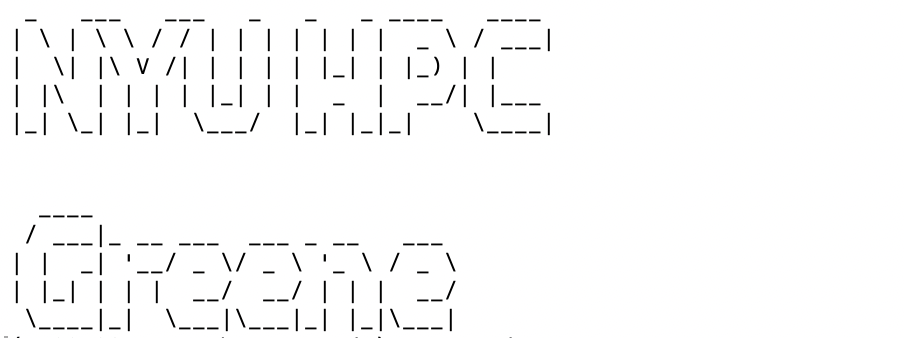


## Understanding the Filesystem

The Greene HPC cluster has different directories optimized for various storage needs.

| Directory  | Variable   | Purpose                | Flushed After | Quota             |
|------------|------------|------------------------|---------------|-------------------|
| `/archive` | `$ARCHIVE` | Long-term storage      | No            | 2TB / 20K inodes  |
| `/home`    | `$HOME`    | Configuration files    | No            | 50GB / 30K inodes |
| `/scratch` | `$SCRATCH` | Temporary data storage | Yes (60 days) | 5TB / 1M inodes   |
| `/vast` | `$VAST` | Workflows with very high read/write demands | Yes (60 days) | 2TB / 5M inodes   |


- **Check Your Quota:**

  ```bash
  myquota
  ```

- **Recommended:** Store the data you want to keep in `/scratch/[netid]` and temporary data in `/tmp`.


## Running Interactive Jobs

When you need to run scripts or perform debugging interactively, follow the steps below.

### Typical Workflow

1. Log in: Greene’s login node.
2. Log in to Burst node.
3. Request a job / computational resource and wait until Slurm grants it.
  - You always need to request a job for GPUs.
4. Execute singularity and start container instance.
5. Activate conda environment with your own deep learning libraries.
6. Run your code, make changes/debugging.

### Accounts and Partitions

- **Account:** `ds_ga_1011_001-2025fa`

- **Partitions:**
  - `interactive` (for lightweight tasks)
  - `n1s8-v100-1` (for GPU tasks)
  - `n1s16-v100-2`
  - `c12m85-a100-1`
  - `c24m170-a100-2`
  - `n1s8-t4-1`

#### Understanding Partitions

- **Partitions** are specific resources or queues on the cluster.

---

### Scripts and File Operations


```bash
ssh burst
```

For non-GPU tasks, use the `interactive` partition.

**Requesting an Interactive Session:**

```bash
srun --account=ds_ga_1011_001-2025fa --partition=interactive --pty /bin/bash
```

- **Options:**
  - `--account`: Specify account.
  - `--partition`: Choose partition.
  - `--pty /bin/bash`: Open an interactive shell.

> **Tip:** After allocation, verify the node:

```bash
hostname
```

---

### GPU Access

For GPU tasks, request resources from a GPU partition. Each student is assigned to Slurm account with 300 GPU hours (18000 minutes) and sufficient CPU time.

**Requesting a GPU Session:**

```bash
srun --account=ds_ga_1011_001-2025fa --partition=c12m85-a100-1 --gres=gpu:1 --time=1:00:00 --pty /bin/bash
```

- **Options:**
  - `--gres=gpu:1`: Request one GPU.
  - `--time=1:00:00`: Set time limit.

**Verify GPU Allocation:**

```bash
nvidia-smi
```
---

### Monitoring Jobs

Check the status of your jobs in the Slurm queue.

**Check Your Jobs:**

```bash
squeue -u [netid]
```

**Cancel a Job:**

- **Exit the Session:** Press `Ctrl+D` or type `exit`.

---

# Setting Up Singularity and Conda

##Singularity:

Singularity is a container platform designed for high-performance computing (HPC) and scientific workloads. It allows you to package software, libraries, and dependencies into a portable image that can run consistently across different systems. Unlike Docker, Singularity integrates smoothly with HPC clusters, respecting user permissions and supporting seamless access to files and GPUs.

### Copying the Filesystem Image

Copy the empty filesystem image (once per semester).

**Get on a GPU Node:**

```bash
srun --account=ds_ga_1011_001-2025fa --partition=c12m85-a100-1 --gres=gpu:a100:1 --time=04:00:00 --pty /bin/bash
```

**Navigate to Scratch Directory:**

```bash
cd /scratch/[netid]
```

**Download Overlay Filesystem:**

```bash
scp greene-dtn:/scratch/work/public/overlay-fs-ext3/overlay-25GB-500K.ext3.gz .
```

Filesystems can be mounted as read-write (`rw`) or read-only (`ro`) when we use it with singularity.
- read-write: use this one when setting up env (installing conda, libs, other static files)
- read-only: use this one when running your jobs. It has to be read-only since multiple processes will access the same image. It will crash if any job has already mounted it as read-write.

### Unzipping the Image

Unzip the ext3 filesystem (takes about 5 minutes).

```bash
gunzip -vvv ./overlay-25GB-500K.ext3.gz
```

```bash
# Copy the appropriate singularity image to the current working directory
scp -rp greene-dtn:/scratch/work/public/singularity/ubuntu-20.04.3.sif .
```

##Conda:

Conda is an open-source package and environment manager. It helps you install, update, and manage software libraries across different languages (Python, R, etc.). Conda also allows you to create isolated environments so that different projects can use different versions of libraries without conflicts.

### Installing Conda

Install Conda inside the Singularity container.

**Start Singularity:**

```bash
singularity exec --bind /scratch --nv --overlay  /scratch/[netid]/overlay-25GB-500K.ext3:rw /scratch/[netid]/ubuntu-20.04.3.sif /bin/bash
```

**Inside Singularity:**

```bash
Singularity> cd /ext3/
Singularity> wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
```

Install conda

```bash
bash ./Miniconda3-latest-Linux-x86_64.sh -b -p /ext3/miniconda3
```

- **Installation Prefix:** `/ext3/miniconda3`
- **Modify `~/.bashrc`:** Yes

**Set Up Conda:**

```bash
source /ext3/miniconda3/etc/profile.d/conda.sh
export PATH=/ext3/miniconda3/bin:$PATH
```

---

### Installing Python Libraries

Ensure Conda environment is activated.

```bash
conda create -n nlp_env python==3.11
conda activate nlp_env
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
```

### Testing the Setup

Test PyTorch and GPU access:

```python
python

>>> import torch
>>> torch.cuda.is_available()
True
>>> x = torch.tensor([1, 2])
>>> x
tensor([1, 2])
```

---


## Running Batch Jobs

For longer experiments or multiple jobs, use batch jobs.

### Batch Job Workflow

1. **Log In** to Greene.

2. **Submit an `sbatch` Script**.

### Submitting a Job Script

```bash
Request an interactive shell
```

**Download Python Script:**

```bash
cd /scratch/[netid]
wget https://nyu-cs2590.github.io/course-material/fall2023/section/sec03/test_gpu.py
```

**Write the Batch Script:**

```bash
#!/bin/bash
#SBATCH --job-name=job_wgpu
#SBATCH --account=ds_ga_1011_001-2025fa
#SBATCH --partition=c12m85-a100-1
#SBATCH --open-mode=append
#SBATCH --output=./%j_%x.out
#SBATCH --error=./%j_%x.err
#SBATCH --export=ALL
#SBATCH --time=00:10:00
#SBATCH --gres=gpu:1
#SBATCH --requeue


singularity exec --bind /scratch --nv --overlay  /scratch/[netid]/overlay-25GB-500K.ext3:rw /scratch/[netid]/ubuntu-20.04.3.sif /bin/bash -c "
source /ext3/miniconda3/etc/profile.d/conda.sh
conda activate nlp_env
cd /scratch/vn2263/hpc_and_pytorch_tutorial/
python3 ./test_gpu.py
"
```

**Submit Batch Job:**

```bash
sbatch gpu_job.slurm
```

**Check Job Status:**

```bash
squeue -u [netid]
```

### Checking Job Output

After job completion, check the output log.


### SCP Tutorial How to copy files around?

* Use Git and you don't need any of these :)

* From local to Greene, on local run

```bash
scp [optional flags] [file-path] [netid]@greene.hpc.nyu.edu:[greene-destination-path]
```

* From Greene to local, on local run

```bash
scp [optional flags] [netid]@greene.hpc.nyu.edu:[file-path] [local-destination-path]
```

* From Greene to GCP, on GCP run

```bash
scp [optional flags] greene-dtn:[file-path] [gcp-destination-path]
```

* From GCP to Greene, on GCP run

```bash
scp [optional flags] [file-path] greene-dtn:[greene-destination-path]
```

* From local to GCP: local → Greene → GCP
* From GCP to local: GCP → Greene → Local

## Running Jupyter Notebook on HPC
## Google Cloud Bursting
1. Open the web browser and go to `https://ood-burst-001.hpc.nyu.edu/`
2. Log in and open Jupyter Notebook from the Interactive Apps section.
3. Submit your request with the following settings:
   - Number of GPUs: 1
   - Slurm Account: `ds_ga_1011_001-2025fa`
   - Slurm Partition: `c12m85-a100-1` or `n1s8-v100-1`
   - Root Directory: `scratch`
   - Number of Hours: 1

# Part 2: The XOR Problem

The **XOR (Exclusive OR)** problem is a classic example in machine learning, representing a simple non-linear classification task. The goal is to build a model that can predict the output of the XOR function given two binary inputs.

**XOR Truth Table**:

| Input X1 | Input X2 | Output Y |
|----------|----------|----------|
|    0     |     0    |     0    |
|    0     |     1    |     1    |
|    1     |     0    |     1    |
|    1     |     1    |     0    |

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

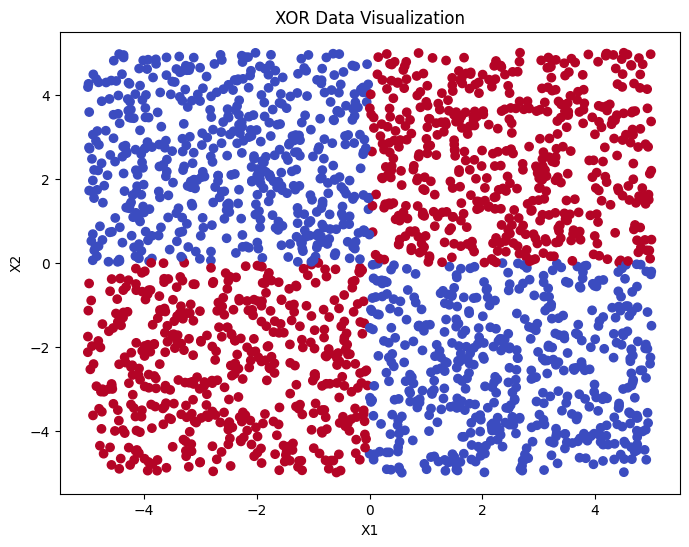

In [2]:
def generate_xor_data(num_samples):
    X = torch.tensor([[random.uniform(-5, 5), random.uniform(-5, 5)] for _ in range(num_samples)]).float()
    y = torch.tensor([1 if x1 * x2 > 0 else 0 for x1, x2 in X]).float()
    return X, y

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

num_samples = 2000
X, y = generate_xor_data(num_samples)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
plt.title('XOR Data Visualization')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()


### Splitting the Data

We need to split our data into training and testing sets.

In [3]:
def split_data(X, y, train_ratio=0.8):
    n_train = int(train_ratio * len(X))
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y)


### Binary Logistic Regression

First, let's attempt to solve the XOR problem using a simple logistic regression model.

#### Model Definition

In [4]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

log_reg_model = LogisticRegression(input_dim=2)

In [5]:
loss_fn = nn.BCELoss()
optimizer_log_reg = optim.SGD(log_reg_model.parameters(), lr=0.01)

In [6]:
def accuracy(targs, preds):
  return torch.mean(torch.eq(targs,preds).float())

#### Training the Model

In [7]:
def train_model(model, X_train, y_train, loss_fn, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

In [8]:
train_model(log_reg_model, X_train, y_train, loss_fn, optimizer_log_reg, epochs=1000)

Epoch 0/1000, Loss: 1.1428076028823853
Epoch 100/1000, Loss: 0.7187635898590088
Epoch 200/1000, Loss: 0.6940609812736511
Epoch 300/1000, Loss: 0.6932699680328369
Epoch 400/1000, Loss: 0.6930538415908813
Epoch 500/1000, Loss: 0.6929271817207336
Epoch 600/1000, Loss: 0.6928504109382629
Epoch 700/1000, Loss: 0.6928038001060486
Epoch 800/1000, Loss: 0.6927754282951355
Epoch 900/1000, Loss: 0.692758321762085


**Discussion**: What is the expected accuracy of Logistic Regression when applied to the XOR problem, and why?


#### Evaluating the Model

In [11]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
      test_outputs = model(X_test).squeeze()
      predictions = (test_outputs >= 0.5).float()
      accuracy = (predictions == y_test).float().mean().item()
    return accuracy

log_reg_accuracy = evaluate_model(log_reg_model, X_test, y_test)
print(f'Logistic Regression Test Accuracy: {log_reg_accuracy:.4f}')


Logistic Regression Test Accuracy: 0.5875


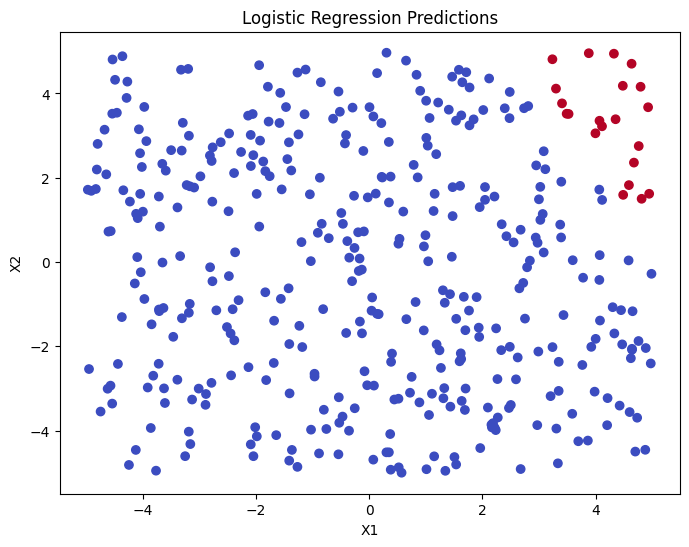

In [12]:
def visualize_predictions(X_test, predictions, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, cmap='coolwarm')
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

log_reg_predictions = (log_reg_model(X_test).squeeze() >= 0.5).float()
visualize_predictions(X_test, log_reg_predictions, "Logistic Regression Predictions")

### Multi-Layer Perceptron


In [13]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(MultiLayerPerceptron, self).__init__()

        # Define the layers

        # Activation function for hidden layer: ReLU

        # Activation function for output layer: Sigmoid

    def forward(self, x):
        # Apply ReLU after the first layer (hidden layer)

        # Apply Sigmoid after the second layer (output layer)

        return x

mlp_model = MultiLayerPerceptron(input_dim=2)

In [ ]:
optimizer_mlp = optim.SGD(mlp_model.parameters(), lr=0.1)
train_model(mlp_model, X_train, y_train, loss_fn, optimizer_mlp, epochs=1000)

In [ ]:
mlp_accuracy = evaluate_model(mlp_model, X_test, y_test)
print(f'MLP Test Accuracy: {mlp_accuracy:.4f}')

In [ ]:
mlp_predictions = (mlp_model(X_test).squeeze() >= 0.5).float()
visualize_predictions(X_test, mlp_predictions, "MLP Predictions")

# Part 3: Transformer

[![The Transformer Encoders and Decoders](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)](https://jalammar.github.io/images/t/The_transformer_encoders_decoders.png)

Source: [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

In [ ]:
def build_transformer(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(d_model, h, dropout)
    ff = FeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    return model

In [ ]:
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encoder(self.src_embed(src), src_mask)
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

[![Encoder Layer](https://jalammar.github.io/images/t/Transformer_encoder.png)](https://jalammar.github.io/images/t/Transformer_encoder.png)

Source: [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([SublayerConnection(size, dropout) for _ in range(2)])
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([layer for _ in range(N)])
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

Translate:



```
The animal didn't cross the street because it was too tired
```

[![Dot product](https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)](https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png)

### Obtaining the Query, Key and Value matrices

[![Attention](https://jalammar.github.io/images/t/self-attention-matrix-calculation.png)](https://jalammar.github.io/images/t/self-attention-matrix-calculation.png)


[![Multi-head attention](https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)](https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)


Source: [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def attention(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            # Expand the mask to fit the number of attention heads
            mask = mask.unsqueeze(1)  # (batch_size, 1, 1, seq_len) -> (batch_size, 1, seq_len)
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = torch.softmax(scores, dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn

    def forward(self, query, key, value, mask=None):
        nbatches = query.size(0)
        query, key, value = [lin(x).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
                             for lin, x in zip(self.linears, (query, key, value))]

        x, self.attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)

        return self.linears[-1](x)

In [ ]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class FeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(d_model, d_ff)
        self.fc2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(F.relu(self.fc1(x))))


[![Encoder Layer](https://jalammar.github.io/images/t/transformer_decoding_1.gif)](https://jalammar.github.io/images/t/transformer_decoding_1.gif)

Source: [Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = nn.ModuleList([SublayerConnection(size, dropout) for _ in range(3)])
        self.size = size

    def forward(self, x, memory, src_mask, tgt_mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.feed_forward)

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([layer for _ in range(N)])
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# Generator for the final linear layer and softmax


class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim=-1)

In [ ]:
import copy
import math

src_vocab = 10000
tgt_vocab = 10000
model = build_transformer(src_vocab, tgt_vocab)

src = torch.randint(0, src_vocab, (2, 10))  # (batch_size, src_seq_len)
tgt = torch.randint(0, tgt_vocab, (2, 10))  # (batch_size, tgt_seq_len)
src_mask = torch.ones(2, 1, 10)  # Dummy mask
tgt_mask = torch.ones(2, 1, 10)  # Dummy mask

output = model(src, tgt, src_mask, tgt_mask)
print(output.shape)  # Should be (batch_size, tgt_seq_len, d_model)
